In [ ]:
# ✔️ 필요 모듈 불러오기
import re
import socket
import time
import urllib.request
import requests
import warnings
import whois
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime
from googlesearch import search
from patterns import *
import urllib3
import random
from urllib.parse import urlparse

from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# SSL 경고 비활성화
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
warnings.filterwarnings("ignore")

# Path of your local server. Different for different OSs.
LOCALHOST_PATH = "/Library/WebServer/Documents/"
DIRECTORY_NAME = "Malicious-Web-Content-Detection-Using-Machine-Learning"

# ============================================================================
# 🔧 개선된 유틸리티 함수들
# ============================================================================

# ===== Patch: robust DNS check (IPv4/IPv6) =====
def robust_dns_check(hostname: str) -> bool:
    try:
        # IPv4/IPv6 모두 조회
        infos = socket.getaddrinfo(hostname, None)
        return len(infos) > 0
    except socket.gaierror:
        # 'www.' 제거 재시도
        if hostname.startswith('www.'):
            try:
                return len(socket.getaddrinfo(hostname[4:], None)) > 0
            except socket.gaierror:
                return False
        return False

def safe_url_request_improved(url, max_retries=2, timeout=10):
    """개선된 안전한 URL 요청 처리"""
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate',
        'Connection': 'keep-alive',
    }
    
    # URL 전처리
    if not url.startswith(('http://', 'https://')):
        url = 'http://' + url
    
    for attempt in range(max_retries + 1):
        try:
            if attempt > 0:
                time.sleep(random.uniform(0.5, 2))
            
            response = requests.get(
                url, 
                headers=headers,
                timeout=timeout,
                verify=False,
                allow_redirects=True,
                stream=True
            )
            
            response.raise_for_status()
            
            # 콘텐츠 크기 제한
            content_length = response.headers.get('content-length')
            if content_length and int(content_length) > 5 * 1024 * 1024:  # 5MB 제한
                return None, None
            
            soup = BeautifulSoup(response.content, 'html.parser')
            return response, soup
            
        except (requests.exceptions.SSLError, 
                requests.exceptions.ConnectionError,
                requests.exceptions.Timeout,
                requests.exceptions.TooManyRedirects) as e:
            if attempt == max_retries:
                return None, None
            continue
        except Exception:
            return None, None
    
    return None, None

# ===== Patch: whois (두 패키지 모두 호환) =====
def safe_whois_query(hostname):
    """
    - pip install whois  (whois.query)
    - 또는 pip install python-whois (whois.whois)
    둘 중 무엇이 깔려 있어도 동작하도록 처리.
    """
    try:
        # 시나리오 1: whois.query API
        q = getattr(whois, 'query', None)
        if callable(q):
            domain = q(hostname)
            if domain:
                return domain
    except Exception:
        pass

    try:
        # 시나리오 2: whois.whois API (dict-like)
        w = getattr(whois, 'whois', None)
        if callable(w):
            data = w(hostname)
            class _Domain:
                def __init__(self, d):
                    self.name = d.get('domain_name')
                    self.creation_date = d.get('creation_date')
                    self.expiration_date = d.get('expiration_date')
            return _Domain(data) if data else None
    except Exception:
        pass

    # 'www.' 제거 재시도
    if hostname.startswith('www.'):
        return safe_whois_query(hostname[4:])

    return None

# ============================================================================
# 🎯 기존 특징 추출 함수들 (그대로 유지)
# ============================================================================

def having_ip_address(url):
    ip_address_pattern = ipv4_pattern + "|" + ipv6_pattern
    match = re.search(ip_address_pattern, url)
    return -1 if match else 1

def url_length(url):
    if len(url) < 54:
        return 1
    if 54 <= len(url) <= 75:
        return 0
    return -1

def shortening_service(url):
    match = re.search(shortening_services, url)
    return -1 if match else 1

def having_at_symbol(url):
    match = re.search('@', url)
    return -1 if match else 1

def double_slash_redirecting(url):
    last_double_slash = url.rfind('//')
    return -1 if last_double_slash > 6 else 1

def prefix_suffix(domain):
    match = re.search('-', domain)
    return -1 if match else 1

def having_sub_domain(url):
    if having_ip_address(url) == -1:
        match = re.search(
            '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
            '([01]?\\d\\d?|2[0-4]\\d|25[0-5]))|(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}',
            url)
        pos = match.end()
        url = url[pos:]
    num_dots = [x.start() for x in re.finditer(r'\.', url)]
    if len(num_dots) <= 3:
        return 1
    elif len(num_dots) == 4:
        return 0
    else:
        return -1

def domain_registration_length(domain):
    try:
        expiration_date = domain.expiration_date
        today = datetime.now()
        
        if expiration_date:
            if isinstance(expiration_date, list):
                expiration_date = expiration_date[0]
            registration_length = abs((expiration_date - today).days)
            return 1 if registration_length / 365 > 1 else -1
    except:
        pass
    return 0  # 중립값


# ===== Patch: favicon (조기 반환 제거, 정확도 개선) =====
def favicon(wiki, soup, domain):
    if not soup:
        return 0
    try:
        links = soup.find_all('link', href=True)
        if not links:
            return 1
        safe_cnt, total = 0, 0
        for link in links:
            href = link.get('href', '').strip()
            if not href:
                continue
            total += 1
            # 절대/상대 URL normalize
            if href.startswith('//'):
                href_host = get_hostname_from_url('http:' + href)
            elif href.startswith(('http://', 'https://')):
                href_host = get_hostname_from_url(href)
            else:
                href_host = domain  # 상대경로면 same-origin 취급
            if domain in href_host or (wiki and get_hostname_from_url(wiki) in href):
                safe_cnt += 1
        if total == 0:
            return 1
        ratio = safe_cnt / total * 100
        return 1 if ratio >= 50 else (0 if ratio >= 20 else -1)
    except Exception:
        return 1

def https_token(url):
    match = re.search(http_https, url)
    if match and match.start() == 0:
        url = url[match.end():]
    match = re.search('http|https', url)
    return -1 if match else 1

def request_url(wiki, soup, domain):
    if not soup:
        return 0
    try:
        i = 0
        success = 0
        
        for tag_name in ['img', 'audio', 'embed', 'iframe']:
            for tag in soup.find_all(tag_name, src=True):
                src = tag.get('src', '')
                dots = [x.start() for x in re.finditer(r'\.', src)]
                if wiki in src or domain in src or len(dots) == 1:
                    success += 1
                i += 1
        
        if i == 0:
            return 1
            
        percentage = success / float(i) * 100
        if percentage < 22.0:
            return 1
        elif 22.0 <= percentage < 61.0:
            return 0
        else:
            return -1
    except:
        return 1

def url_of_anchor(wiki, soup, domain):
    if not soup:
        return 0
    try:
        i = 0
        unsafe = 0
        for a in soup.find_all('a', href=True):
            href = a.get('href', '')
            if "#" in href or "javascript" in href.lower() or "mailto" in href.lower() or not (
                    wiki in href or domain in href):
                unsafe += 1
            i += 1
        
        if i == 0:
            return 1
            
        percentage = unsafe / float(i) * 100
        if percentage < 31.0:
            return 1
        elif 31.0 <= percentage < 67.0:
            return 0
        else:
            return -1
    except:
        return 1

def links_in_tags(wiki, soup, domain):
    if not soup:
        return 0
    try:
        i = 0
        success = 0
        
        for link in soup.find_all('link', href=True):
            href = link.get('href', '')
            dots = [x.start() for x in re.finditer(r'\.', href)]
            if wiki in href or domain in href or len(dots) == 1:
                success += 1
            i += 1

        for script in soup.find_all('script', src=True):
            src = script.get('src', '')
            dots = [x.start() for x in re.finditer(r'\.', src)]
            if wiki in src or domain in src or len(dots) == 1:
                success += 1
            i += 1
        
        if i == 0:
            return 1
            
        percentage = success / float(i) * 100
        if percentage < 17.0:
            return 1
        elif 17.0 <= percentage < 81.0:
            return 0
        else:
            return -1
    except:
        return 1

# ===== Patch: sfh (여러 form 종합 판단) =====
def sfh(wiki, soup, domain):
    if not soup:
        return 1
    try:
        forms = soup.find_all('form', action=True)
        if not forms:
            return 1
        neg, mid, pos = 0, 0, 0
        for form in forms:
            action = (form.get('action') or '').strip().lower()
            if action in ("", "about:blank"):
                neg += 1
            elif (domain and domain.lower() in action) or (wiki and get_hostname_from_url(wiki).lower() in action):
                pos += 1
            else:
                mid += 1
        # 다수결
        if neg > max(mid, pos):
            return -1
        if mid >= pos:
            return 0
        return 1
    except Exception:
        return 1

def submitting_to_email(soup):
    if not soup:
        return 1
    try:
        for form in soup.find_all('form', action=True):
            action = form.get('action', '')
            if "mailto:" in action:
                return -1
    except:
        pass
    return 1

def abnormal_url(domain, url):
    try:
        if domain and hasattr(domain, 'name') and domain.name:
            hostname = domain.name
            match = re.search(hostname, url)
            return 1 if match else -1
    except:
        pass
    return 0

def i_frame(soup):
    if not soup:
        return 1
    try:
        for iframe in soup.find_all(['iframe', 'i_frame'], width=True, height=True):
            width = iframe.get('width', '')
            height = iframe.get('height', '')
            frameborder = iframe.get('frameBorder', iframe.get('frameborder', ''))
            
            if width == "0" and height == "0" and frameborder == "0":
                return -1
            if width == "0" or height == "0" or frameborder == "0":
                return 0
    except:
        pass
    return 1

def age_of_domain(domain):
    try:
        if domain and hasattr(domain, 'creation_date') and domain.creation_date:
            creation_date = domain.creation_date
            if isinstance(creation_date, list):
                creation_date = creation_date[0]
            
            today = datetime.now()
            age_days = abs((today - creation_date).days)
            return 1 if age_days / 30 >= 6 else -1
    except:
        pass
    return 0

def web_traffic_alternative(url):
    """Alexa 대신 다른 방법으로 트래픽 추정"""
    try:
        # 간단한 휴리스틱: 도메인 길이와 구조로 판단
        hostname = get_hostname_from_url(url)
        
        # 유명한 도메인들 (간단한 화이트리스트)
        popular_domains = [
            'google.com', 'youtube.com', 'facebook.com', 'twitter.com', 
            'instagram.com', 'linkedin.com', 'github.com', 'stackoverflow.com',
            'wikipedia.org', 'amazon.com', 'microsoft.com', 'apple.com'
        ]
        
        for domain in popular_domains:
            if domain in hostname.lower():
                return 1
        
        # 도메인 구조 기반 점수
        if len(hostname.split('.')) <= 2 and len(hostname) < 15:
            return 1
        elif len(hostname) > 30 or len(hostname.split('.')) > 4:
            return -1
        else:
            return 0
    except:
        return 0

# ===== Patch: google index (패키지 차이 흡수 + 빠른 실패) =====
def google_index_safe(url):
    """
    googlesearch 패키지 군의 파라미터 차이를 흡수.
    실패/차단 시 0 반환.
    """
    try:
        time.sleep(random.uniform(0.3, 0.8))  # rate-limit 배려(짧게)
        query = f"site:{get_hostname_from_url(url)}"
        # 우선 기본 시그니처
        try:
            results = list(search(query, num_results=3))
            return 1 if results else -1
        except TypeError:
            # 대체 시그니처 (다른 패키지)
            results = list(search(query, num=3, stop=3, pause=0.5))
            return 1 if results else -1
    except Exception:
        return 0

def statistical_report(url, hostname):
    """통계 리포트 (IP 기반)"""
    try:
        ip_address = socket.gethostbyname(hostname)
    except:
        return 0  # DNS 실패 시 중립값
    
    # 알려진 악성 도메인/IP 패턴
    url_match = re.search(
        r'at\.ua|usa\.cc|baltazarpresentes\.com\.br|pe\.hu|esy\.es|hol\.es|sweddy\.com|myjino\.ru|96\.lt|ow\.ly', url)
    ip_match = re.search(
        '146\.112\.61\.108|213\.174\.157\.151|121\.50\.168\.88|192\.185\.217\.116|78\.46\.211\.158|181\.174\.165\.13|46\.242\.145\.103|121\.50\.168\.40|83\.125\.22\.219|46\.242\.145\.98|'
        '107\.151\.148\.44|107\.151\.148\.107|64\.70\.19\.203|199\.184\.144\.27|107\.151\.148\.108|107\.151\.148\.109|119\.28\.52\.61|54\.83\.43\.69|52\.69\.166\.231|216\.58\.192\.225|'
        '118\.184\.25\.86|67\.208\.74\.71|23\.253\.126\.58|104\.239\.157\.210|175\.126\.123\.219|141\.8\.224\.221|10\.10\.10\.10|43\.229\.108\.32|103\.232\.215\.140|69\.172\.201\.153|'
        '216\.218\.185\.162|54\.225\.104\.146|103\.243\.24\.98|199\.59\.243\.120|31\.170\.160\.61|213\.19\.128\.77|62\.113\.226\.131|208\.100\.26\.234|195\.16\.127\.102|195\.16\.127\.157|'
        '34\.196\.13\.28|103\.224\.212\.222|172\.217\.4\.225|54\.72\.9\.51|192\.64\.147\.141|198\.200\.56\.183|23\.253\.164\.103|52\.48\.191\.26|52\.214\.197\.72|87\.98\.255\.18|209\.99\.17\.27|'
        '216\.38\.62\.18|104\.130\.124\.96|47\.89\.58\.141|78\.46\.211\.158|54\.86\.225\.156|54\.82\.156\.19|37\.157\.192\.102|204\.11\.56\.48|110\.34\.231\.42',
        ip_address)
    
    if url_match or ip_match:
        return -1
    else:
        return 1

def get_hostname_from_url(url: str) -> str:
    if not url.startswith(('http://', 'https://')):
        url = 'http://' + url  # scheme 보정
    parsed = urlparse(url)
    host = parsed.netloc or parsed.path.split('/')[0]
    # strip 'www.'
    if host.lower().startswith('www.'):
        host = host[4:]
    return host

# ============================================================================
# 🚀 개선된 메인 함수 (단계별 fallback 적용)
# ============================================================================

def extract_features_with_fallback(url):
    """
    단계별 fallback이 적용된 특징 추출 함수
    """
    status = []
    hostname = get_hostname_from_url(url)
    
    # === 1단계: URL 기반 특징 (항상 추출 가능) ===
    try:
        status.extend([
            having_ip_address(url),          # F1
            url_length(url),                 # F2  
            shortening_service(url),         # F3
            having_at_symbol(url),           # F4
            double_slash_redirecting(url),   # F5
            prefix_suffix(hostname),         # F6
            having_sub_domain(url),          # F7
        ])
    except Exception as e:
        print(f"URL 특징 추출 오류: {e}")
        status.extend([0] * 7)
    
    # === 2단계: DNS 해석 및 whois 조회 ===
    dns_available = robust_dns_check(hostname)
    domain = None
    
    if dns_available:
        domain = safe_whois_query(hostname)
        dns_status = 1 if domain else 0
    else:
        dns_status = -1
    
    # 도메인 등록 기간
    try:
        if domain:
            status.append(domain_registration_length(domain))  # F8
        else:
            status.append(0 if dns_available else -1)
    except:
        status.append(0)
    
    # === 3단계: HTTP 요청 및 HTML 파싱 ===
    if dns_available:
        response, soup = safe_url_request_improved(url)
        http_available = (response is not None and soup is not None)
    else:
        response, soup = None, None
        http_available = False
    
    # HTML 기반 특징들
    try:
        if http_available:
            status.extend([
                favicon(url, soup, hostname),           # F9
                https_token(url),                       # F10
                request_url(url, soup, hostname),       # F11
                url_of_anchor(url, soup, hostname),     # F12
                links_in_tags(url, soup, hostname),     # F13
                sfh(url, soup, hostname),               # F14
                submitting_to_email(soup),              # F15
            ])
        else:
            # HTTP 실패 시 URL 기반으로만 판단 가능한 것들
            status.extend([
                0,                           # F9 - favicon (중립)
                https_token(url),           # F10 - https_token (URL만으로 판단 가능)
                0,                          # F11 - request_url (중립)
                0,                          # F12 - url_of_anchor (중립)
                0,                          # F13 - links_in_tags (중립)
                1,                          # F14 - sfh (기본값: 안전)
                1,                          # F15 - submitting_to_email (기본값: 안전)
            ])
    except Exception as e:
        print(f"HTML 특징 추출 오류: {e}")
        status.extend([0] * 7)
    
    # === 4단계: 도메인 기반 특징들 ===
    try:
        if domain:
            status.extend([
                abnormal_url(domain, url),    # F16
                i_frame(soup),                # F17
                age_of_domain(domain),        # F18
            ])
        else:
            status.extend([
                0 if dns_available else -1,  # F16
                i_frame(soup) if http_available else 1,  # F17
                0 if dns_available else -1,  # F18
            ])
    except:
        status.extend([0, 1, 0])
    
    # === 5단계: 외부 서비스 의존 특징들 ===
    status.append(dns_status)                    # F19 - DNS
    status.append(web_traffic_alternative(url))  # F20 - 웹 트래픽 (대체 방법)
    
    # Google 인덱스 (rate limiting 고려)
    try:
        status.append(google_index_safe(url))    # F21
    except:
        status.append(0)
    
    # 통계 리포트
    try:
        status.append(statistical_report(url, hostname))  # F22
    except:
        status.append(0)
    
    return status

# ============================================================================
# 🔄 배치 처리 함수 (개선됨)
# ============================================================================

def extract_features_batch_robust(urls, batch_size=25):
    """
    견고한 배치 처리 - 더 작은 배치와 더 많은 휴식
    """
    features_list = []
    failed_urls = []
    
    for i in range(0, len(urls), batch_size):
        batch_urls = urls[i:i+batch_size]
        batch_num = i//batch_size + 1
        total_batches = (len(urls)-1)//batch_size + 1
        
        print(f"📦 배치 {batch_num}/{total_batches} 처리 중 ({len(batch_urls)}개 URL)...")
        
        batch_features = []
        for j, url in enumerate(tqdm(batch_urls, desc=f"배치 {batch_num}")):
            try:
                features = extract_features_with_fallback(url)
                batch_features.append(features)
                
                # URL 간 휴식 (서버 부하 방지)
                if j < len(batch_urls) - 1:
                    time.sleep(random.uniform(0.1, 0.5))
                    
            except Exception as e:
                print(f"💥 URL 처리 실패: {url[:50]}... - {str(e)[:100]}")
                batch_features.append([0] * 22)  # 중립값으로 설정
                failed_urls.append(url)
        
        features_list.extend(batch_features)
        
        # 배치 간 휴식
        if i + batch_size < len(urls):
            sleep_time = random.uniform(2, 5)
            print(f"💤 {sleep_time:.1f}초 휴식...")
            time.sleep(sleep_time)
    
    print(f"✅ 처리 완료! 실패한 URL: {len(failed_urls)}개")
    if failed_urls:
        print("실패 URL 샘플:", failed_urls[:5])
    
    return features_list

# ============================================================================
# 📊 CSV 처리 함수 (그대로 유지)
# ============================================================================

def extract_features_from_csv(csv_path, url_column, label_column=None):
    """CSV에서 URL 로드 + 특징 추출"""
    df = pd.read_csv(csv_path, encoding="latin1") 
    features_list = []
    labels = []

    print(f"📄 CSV 로드 완료: {len(df)}개 URL")
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="특징 추출"):
        url = row[url_column]
        try:
            features = extract_features_with_fallback(url)
        except Exception as e:
            print(f"행 처리 오류: {e}")
            features = [0] * 22
        features_list.append(features)

        if label_column:
            labels.append(row[label_column])

    feature_df = pd.DataFrame(features_list, columns=[f"F{i}" for i in range(1, 23)])

    if label_column:
        feature_df["label"] = labels

    return feature_df

<>:462: SyntaxWarning: invalid escape sequence '\.'
<>:463: SyntaxWarning: invalid escape sequence '\.'
<>:464: SyntaxWarning: invalid escape sequence '\.'
<>:465: SyntaxWarning: invalid escape sequence '\.'
<>:466: SyntaxWarning: invalid escape sequence '\.'
<>:467: SyntaxWarning: invalid escape sequence '\.'
<>:462: SyntaxWarning: invalid escape sequence '\.'
<>:463: SyntaxWarning: invalid escape sequence '\.'
<>:464: SyntaxWarning: invalid escape sequence '\.'
<>:465: SyntaxWarning: invalid escape sequence '\.'
<>:466: SyntaxWarning: invalid escape sequence '\.'
<>:467: SyntaxWarning: invalid escape sequence '\.'
C:\Users\dldna\AppData\Local\Temp\ipykernel_17096\284255196.py:462: SyntaxWarning: invalid escape sequence '\.'
  '146\.112\.61\.108|213\.174\.157\.151|121\.50\.168\.88|192\.185\.217\.116|78\.46\.211\.158|181\.174\.165\.13|46\.242\.145\.103|121\.50\.168\.40|83\.125\.22\.219|46\.242\.145\.98|'
C:\Users\dldna\AppData\Local\Temp\ipykernel_17096\284255196.py:463: SyntaxWarning:

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def train_random_forest(df):
    X = df.drop(columns=["label"])
    y = df["label"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred))

    return clf

In [3]:
csv_path = "../dataset/URL dataset_sample.csv"
df_features = extract_features_from_csv(csv_path, url_column="URL", label_column="Labels")

📄 CSV 로드 완료: 5000개 URL


특징 추출:  48%|████▊     | 2423/5000 [5:30:59<1:49:43,  2.55s/it]2025-08-14 20:41:05,605 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
특징 추출:  54%|█████▍    | 2693/5000 [5:58:34<1:45:56,  2.76s/it]

행 처리 오류: label empty or too long


특징 추출: 100%|██████████| 5000/5000 [10:04:44<00:00,  7.26s/it]


In [7]:
model = train_random_forest(df_features)

📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.83      0.80       476
         1.0       0.84      0.77      0.80       524

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



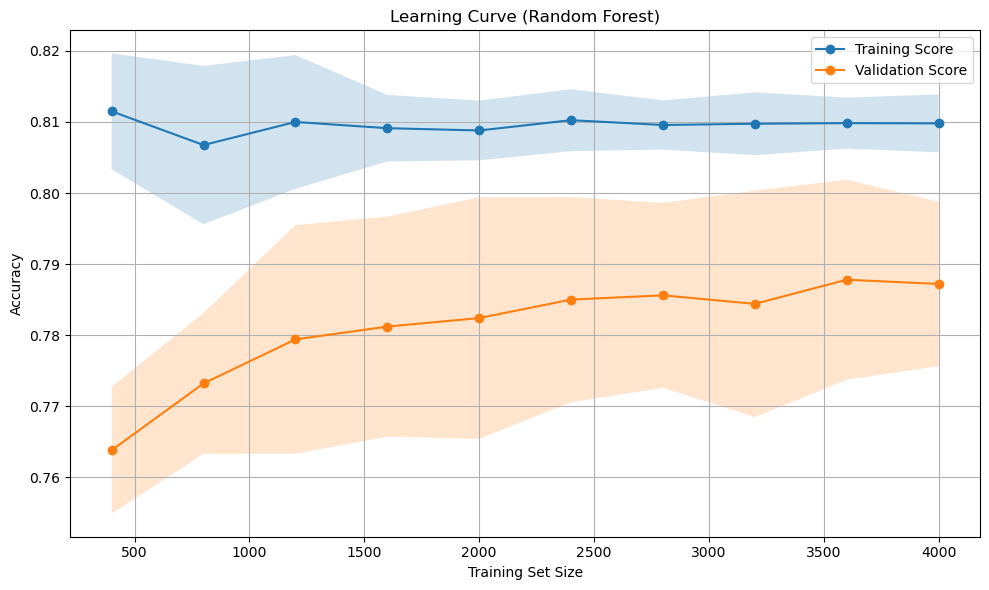

In [15]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(model, X, y, cv=5, scoring='accuracy'):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    val_mean   = np.mean(val_scores, axis=1)
    val_std    = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

    plt.plot(train_sizes, val_mean, 'o-', label='Validation Score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

    plt.title("Learning Curve (Random Forest)")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 사용 예시
X = df_features.drop(columns=["label"])
y = df_features["label"]

plot_learning_curve(RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
), X, y)


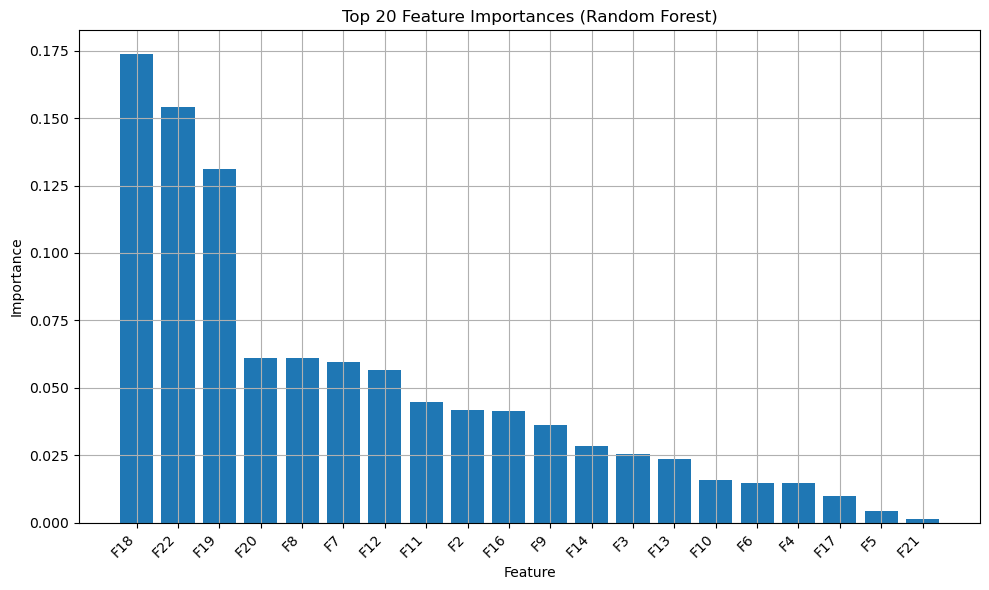

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_feature_importance(model, feature_names, top_n=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]  # 중요도 내림차순
    top_indices = indices[:top_n]

    plt.figure(figsize=(10, 6))
    plt.bar(range(top_n), importances[top_indices], align="center")
    plt.xticks(range(top_n), [feature_names[i] for i in top_indices], rotation=45, ha='right')
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title(f"Top {top_n} Feature Importances (Random Forest)")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# 사용 예시
feature_names = df_features.drop(columns=["label"]).columns
plot_feature_importance(model, feature_names, top_n=20)


| Feature | 의미                                       |
| ------- | ---------------------------------------- |
| **F1**  | having\_ip\_address (URL에 IP가 포함되어 있는가)  |
| **F2**  | url\_length (URL 길이)                     |
| **F3**  | shortening\_service (URL 단축 서비스 사용 여부)   |
| **F4**  | having\_at\_symbol (`@` 포함 여부)           |
| **F5**  | double\_slash\_redirecting (`//` 위치)     |
| **F6**  | prefix\_suffix (도메인에 `-` 포함 여부)          |
| **F7**  | having\_sub\_domain (서브도메인 수)            |
| **F8**  | domain\_registration\_length (도메인 등록 기간) |
| **F9**  | favicon 도메인 일치 여부                        |
| **F10** | https\_token (URL 내부에 http(s) 포함 여부)     |
| **F11** | request\_url (이미지/멀티미디어 리소스 출처)          |
| **F12** | url\_of\_anchor (링크 anchor 신뢰도)          |
| **F13** | links\_in\_tags (스크립트/링크 태그의 출처)         |
| **F14** | sfh (form action의 도메인 일치 여부)             |
| **F15** | submitting\_to\_email (mailto 존재 여부)     |
| **F16** | abnormal\_url (도메인 이름과 URL 일치 여부)        |
| **F17** | i\_frame (iframe의 크기와 보임 여부)             |
| **F18** | age\_of\_domain (도메인 생성 후 경과 시간)         |
| **F19** | DNS 해석 가능 여부                             |
| **F20** | web\_traffic\_alternative (간이 트래픽 추정치)   |
| **F21** | google\_index\_safe (Google 인덱스 포함 여부)   |
| **F22** | statistical\_report (악성 IP/도메인 목록 포함 여부) |


In [9]:
import joblib

# 모델 저장
joblib.dump(model, 'random_forest_model_5000.pkl')

# 저장한 모델 불러오기
loaded_model = joblib.load('random_forest_model_5000.pkl')

In [10]:
import pandas as pd
import numpy as np

def predict_url(model, url):
    """
    단일 URL을 입력받아 모델로 예측하고, 예측 결과와 확률을 반환합니다.
    """
    try:
        # URL에서 특징 추출
        features = extract_features_with_fallback(url)
        feature_df = pd.DataFrame([features], columns=[f"F{i}" for i in range(1, 23)])

        # 예측
        prediction = model.predict(feature_df)[0]
        prediction_proba = model.predict_proba(feature_df)[0]

        # 결과 해석
        confidence = np.max(prediction_proba) * 100
        
        # '악성'과 '정상' 레이블을 코드가 반환하는 레이블에 맞춰 수정합니다.
        # 예를 들어, 1이 정상이고 -1이 악성이라면 아래와 같이 수정합니다.
        # label_map = {1: "정상 (Legitimate)", -1: "악성 (Phishing)"}
        # label_text = label_map.get(prediction, "알 수 없음")
        
        if prediction == 0:
            label_text = "정상 (Legitimate)"
            confidence_text = f"정상일 확률: {confidence:.2f}%"
        elif prediction == 1:
            label_text = "악성 (Phishing)"
            confidence_text = f"악성일 확률: {confidence:.2f}%"
        else:
            label_text = "알 수 없음"
            confidence_text = ""

        return {
            "url": url,
            "prediction": label_text,
            "confidence": confidence_text
        }
    except Exception as e:
        return {
            "url": url,
            "prediction": f"분류 실패: {e}",
            "confidence": "N/A"
        }

def test_urls(model, url_list):
    """
    여러 개의 URL 리스트를 입력받아 예측 결과를 출력합니다.
    """
    print("--- 🎯 URL 분류 결과 ---")
    results = [predict_url(model, url) for url in url_list]
    
    for result in results:
        print(f"URL: {result['url']}")
        print(f"  ➡️ 분류: {result['prediction']}")
        print(f"  ➡️ 신뢰도: {result['confidence']}")
        print("-" * 20)

In [11]:
user_urls = [
    # 정상
    "https://developer.chrome.com/docs/extensions/get-started/tutorial/debug?hl=ko",
    "https://www.google.com",
    "https://smsso.sookmyung.ac.kr/sso/auth?&client_id=EP&response_type=code&state=1754627647397&p_sid=null&rd_c_p=loginparam",
    "https://music.youtube.com/",
    "https://github.com/",
    "https://programmers.co.kr/",
    "https://gemini.google.com/app?hl=ko",
    "https://shopping.naver.com/ns/home",
    "https://smartstore.naver.com/costradersmart/products/10157698777?site_preference=device&NaPm=ct%3Dmeanlrun%7Cci%3Dshopn%7Ctr%3Dnshfum%7Chk%3D9f22acb67ef47759a8ec5ab9c901b08f0e1ac324%7Ctrx%3Dundefined",
    "https://www.weather.go.kr/w/weather/forecast/short-term.do?stnId=109",
    "https://miso.kr/moving-rfq",
    "https://okbfex.kbstar.com/quics?page=C027979&articleId=138965&QSL=F&bbsMode=view#loading"
]

In [12]:
test_urls(model, user_urls)

--- 🎯 URL 분류 결과 ---
URL: https://developer.chrome.com/docs/extensions/get-started/tutorial/debug?hl=ko
  ➡️ 분류: 정상 (Legitimate)
  ➡️ 신뢰도: 정상일 확률: 88.02%
--------------------
URL: https://www.google.com
  ➡️ 분류: 정상 (Legitimate)
  ➡️ 신뢰도: 정상일 확률: 90.28%
--------------------
URL: https://smsso.sookmyung.ac.kr/sso/auth?&client_id=EP&response_type=code&state=1754627647397&p_sid=null&rd_c_p=loginparam
  ➡️ 분류: 정상 (Legitimate)
  ➡️ 신뢰도: 정상일 확률: 90.20%
--------------------
URL: https://music.youtube.com/
  ➡️ 분류: 정상 (Legitimate)
  ➡️ 신뢰도: 정상일 확률: 59.63%
--------------------
URL: https://github.com/
  ➡️ 분류: 정상 (Legitimate)
  ➡️ 신뢰도: 정상일 확률: 90.20%
--------------------
URL: https://programmers.co.kr/
  ➡️ 분류: 정상 (Legitimate)
  ➡️ 신뢰도: 정상일 확률: 50.49%
--------------------
URL: https://gemini.google.com/app?hl=ko
  ➡️ 분류: 정상 (Legitimate)
  ➡️ 신뢰도: 정상일 확률: 65.40%
--------------------
URL: https://shopping.naver.com/ns/home
  ➡️ 분류: 정상 (Legitimate)
  ➡️ 신뢰도: 정상일 확률: 86.04%
--------------------
URL: 

In [13]:
user_urls =["https://raydiums-earn.web.app/",
            "http://allegrolokalnie.pl-oferta3391284678.icu",
            "http://allegrolokalnie.oferta45612341.cfd",
            "https://exodus-wallet.web3srv.com/",
            "https://opentensor-hub.vercel.app/stake",
            "https://forms.zohopublic.com/cazavidccrsagm1",
            "https://seguroihavan.myshopify.com",
            "https://www.saneamento.gerenciamento.site/",
            "https://growthsupllemennts.myshopify.com/products/kit-growth-2-whey-1k...",
            "https://www.solicitudesfd.com/about-us",
            "https://www.cooperativasicredisp.online"
            ]

In [14]:
test_urls(model, user_urls)

2025-08-15 08:58:42,406 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


--- 🎯 URL 분류 결과 ---


2025-08-15 08:58:53,518 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


URL: https://raydiums-earn.web.app/
  ➡️ 분류: 악성 (Phishing)
  ➡️ 신뢰도: 악성일 확률: 59.51%
--------------------
URL: http://allegrolokalnie.pl-oferta3391284678.icu
  ➡️ 분류: 악성 (Phishing)
  ➡️ 신뢰도: 악성일 확률: 69.68%
--------------------
URL: http://allegrolokalnie.oferta45612341.cfd
  ➡️ 분류: 악성 (Phishing)
  ➡️ 신뢰도: 악성일 확률: 68.34%
--------------------
URL: https://exodus-wallet.web3srv.com/
  ➡️ 분류: 악성 (Phishing)
  ➡️ 신뢰도: 악성일 확률: 50.08%
--------------------
URL: https://opentensor-hub.vercel.app/stake
  ➡️ 분류: 정상 (Legitimate)
  ➡️ 신뢰도: 정상일 확률: 60.01%
--------------------
URL: https://forms.zohopublic.com/cazavidccrsagm1
  ➡️ 분류: 정상 (Legitimate)
  ➡️ 신뢰도: 정상일 확률: 62.62%
--------------------
URL: https://seguroihavan.myshopify.com
  ➡️ 분류: 악성 (Phishing)
  ➡️ 신뢰도: 악성일 확률: 78.66%
--------------------
URL: https://www.saneamento.gerenciamento.site/
  ➡️ 분류: 악성 (Phishing)
  ➡️ 신뢰도: 악성일 확률: 79.03%
--------------------
URL: https://growthsupllemennts.myshopify.com/products/kit-growth-2-whey-1k...
  ➡️ 분류

In [5]:
test_csv_path = "../dataset/test_url_dataset_cleaned.csv"
df_test = extract_features_from_csv(test_csv_path, url_column="URL", label_column="label")

📄 CSV 로드 완료: 200개 URL


특징 추출: 100%|██████████| 200/200 [16:21<00:00,  4.91s/it]


In [16]:
from sklearn.metrics import accuracy_score, classification_report


# 2. 입력(X)와 정답(y) 분리
X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

# 3. 예측
predictions = model.predict(X_test)

# 4. 성능 평가
print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.705

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.95      0.76       100
           1       0.90      0.46      0.61       100

    accuracy                           0.70       200
   macro avg       0.77      0.70      0.69       200
weighted avg       0.77      0.70      0.69       200

